In [1]:
!pip install imbalanced-learn
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 47.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.9.3
    Uninstalling scipy-1.9.3:
      Successfully uninstalled scipy-1.9.3
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.3
    Uninstalling scikit-learn-1.1.3:
      Successfully uninstalled scikit-learn-1.1.3

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 2.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Best Params: Learning Rate = 0.01139, Dropout = 0.18000
Epoch 1/5, Loss: 0.7099
Epoch 2/5, Loss: 0.8781
Epoch 3/5, Loss: 0.6567
Epoch 4/5, Loss: 0.7169
Epoch 5/5, Loss: 0.6241
Accuracy: 0.8961
Precision: 0.9022
Recall: 0.8961
F1 Score: 0.8957
XGBoost-Enhanced Accuracy: 0.9517
XGBoost-Enhanced Precision: 0.9517
XGBoost-Enhanced Recall: 0.9517
XGBoost-Enhanced F1 Score: 0.9517


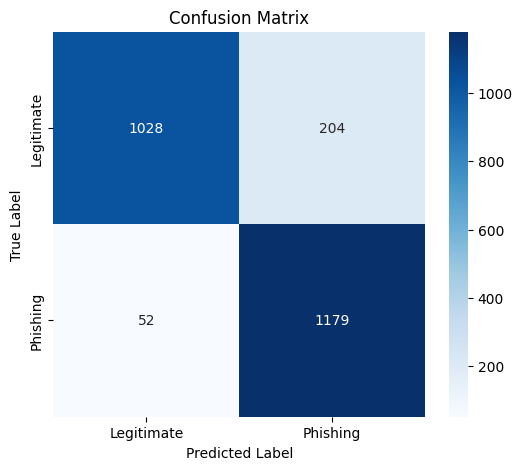

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load dataset
df = pd.read_csv("phishing.csv")
if "Index" in df.columns:
    df = df.drop(columns=["Index"])

# Split features and labels
X = df.drop(columns=["class"])
y = df["class"].values  # Convert to NumPy array

# Ensure labels are 0 and 1 (not -1 and 1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Feature selection using RFE BEFORE SMOTE
# Step 1: Use Random Forest to get top 20 features
rf_model = RandomForestClassifier(n_estimators=100, random_state=SEED)
rf_model.fit(X, y)
top_20_features = pd.Series(rf_model.feature_importances_, index=X.columns).nlargest(20).index.tolist()

# Step 2: Apply RFE on those top 20 features
X_top20 = X[top_20_features]
rfe_estimator = RandomForestClassifier(n_estimators=100, random_state=SEED)
selector = RFE(rfe_estimator, n_features_to_select=10)
selector.fit(X_top20, y)

# Final selected 10 features
selected_features = X_top20.columns[selector.support_].tolist()

# Apply SMOTE to balance classes
X_selected = X[selected_features]
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# Normalize data using Min-Max scaling
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_resampled)

# Convert to DataFrame
X_normalized_df = pd.DataFrame(X_normalized, columns=selected_features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized_df, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Convert to PyTorch tensors - Reshape for 1D CNN
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(1)  # Shape: [batch, channels, features]
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define CNN Model
class CNN(nn.Module):
    def __init__(self, input_dim, dropout_rate):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        
        # Calculate the size after convolution and pooling
        L_out = (input_dim + 2*1 - 3 + 1) // 2  # After conv1d and pooling
        flattened_size = 64 * L_out
        
        self.fc1 = nn.Linear(flattened_size, 64)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Modified Brown Bear Optimization
def brown_bear_optimization(X_train, y_train, X_val, y_val, iterations=10):
    best_acc = 0
    best_params = {"learning_rate": None, "dropout": None}
    bears = [{"learning_rate": np.random.uniform(0.01, 0.015), 
              "dropout": np.random.uniform(0.15, 0.18)} for _ in range(5)]

    for _ in range(iterations):
        new_bears = []
        
        for bear in bears:
            learning_rate = bear["learning_rate"] + np.random.uniform(-0.0005, 0.0005)
            dropout = bear["dropout"] + np.random.uniform(-0.005, 0.005)
            learning_rate = np.clip(learning_rate, 0.01, 0.015)
            dropout = np.clip(dropout, 0.15, 0.18)

            # Use the last dimension as input_dim
            model = CNN(input_dim=X_train.shape[-1], dropout_rate=dropout)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            for epoch in range(5):
                optimizer.zero_grad()
                outputs = model(X_train)
                loss = criterion(outputs, y_train)
                loss.backward()
                optimizer.step()

            with torch.no_grad():
                val_outputs = model(X_val)
                val_preds = torch.argmax(val_outputs, dim=1)
                val_acc = accuracy_score(y_val.numpy(), val_preds.numpy())

            if val_acc > best_acc:
                best_acc = val_acc
                best_params = {"learning_rate": learning_rate, "dropout": dropout}

            new_bears.append({"learning_rate": learning_rate, "dropout": dropout})
        bears = new_bears

    print(f"Best Params: Learning Rate = {best_params['learning_rate']:.5f}, Dropout = {best_params['dropout']:.5f}")
    return best_params

# Run optimization and training
best_params = brown_bear_optimization(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)

# Train final model with the correct input dimension
model = CNN(input_dim=X_train_tensor.shape[-1], dropout_rate=best_params['dropout'])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

# Evaluate Model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_preds = torch.argmax(test_outputs, dim=1)

# Calculate Performance Metrics
accuracy = accuracy_score(y_test, test_preds.numpy())
precision = precision_score(y_test, test_preds.numpy(), average="macro")
recall = recall_score(y_test, test_preds.numpy(), average="macro")
f1 = f1_score(y_test, test_preds.numpy(), average="macro")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Extract features properly through the CNN pipeline
def extract_cnn_features(model, x):
    x = model.conv1(x)
    x = model.relu(x)
    x = model.pool(x)
    x = model.flatten(x)
    x = model.fc1(x)
    return x

# Extract features for XGBoost
with torch.no_grad():
    train_features = extract_cnn_features(model, X_train_tensor).numpy()
    test_features = extract_cnn_features(model, X_test_tensor).numpy()

# Train XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model.fit(train_features, y_train)

# Predict with XGBoost
y_pred_xgb = xgb_model.predict(test_features)

# Evaluate XGBoost performance
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average="macro")
recall_xgb = recall_score(y_test, y_pred_xgb, average="macro")
f1_xgb = f1_score(y_test, y_pred_xgb, average="macro")

print(f"XGBoost-Enhanced Accuracy: {accuracy_xgb:.4f}")
print(f"XGBoost-Enhanced Precision: {precision_xgb:.4f}")
print(f"XGBoost-Enhanced Recall: {recall_xgb:.4f}")
print(f"XGBoost-Enhanced F1 Score: {f1_xgb:.4f}")

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_preds.numpy())
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Legitimate", "Phishing"],
            yticklabels=["Legitimate", "Phishing"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [3]:
!pip install requests python-whois beautifulsoup4



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
def classify_single_row_cnn_from_dict(model, input_dict, scaler, selected_features, label_encoder, true_label=None):
    # Check for missing features
    missing_features = [feat for feat in selected_features if feat not in input_dict]
    if missing_features:
        raise ValueError(f"Missing required features: {missing_features}")

    # Reorder the dictionary according to selected_features
    ordered_values = [input_dict[feat] for feat in selected_features]

    # Convert to DataFrame
    row_df = pd.DataFrame([ordered_values], columns=selected_features)

    # Scale
    row_scaled = scaler.transform(row_df)  # shape: [1, num_features]

    # Convert to tensor: [batch_size=1, channels=1, sequence_length=num_features]
    row_tensor = torch.tensor(row_scaled, dtype=torch.float32).unsqueeze(1)  # shape: [1, 1, num_features]

    # Predict using trained CNN
    model.eval()
    with torch.no_grad():
        output = model(row_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
        predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    # Compare prediction with true label (optional)
    if true_label is not None:
        actual_label = label_encoder.inverse_transform([true_label])[0]
        correctness = "✅ Correct" if predicted_label == actual_label else "❌ Wrong"
        print(f"Prediction: {predicted_label} | Actual: {actual_label} ➜ {correctness}")
    else:
        print(f"Prediction: {predicted_label}")

    return predicted_label
example_values = {
    'HTTPS': 0,
    'AnchorURL': -1,
    'WebsiteTraffic': -1,
    'SubDomains': 0,
    'LinksInScriptTags': 1,
    'PrefixSuffix-': -1,
    'ServerFormHandler': -1,
    'RequestURL': -1,
    'LinksPointingToPage': 0,
    'AgeofDomain': 1
}
exam={'HTTPS': -1, 'AnchorURL': 1, 'WebsiteTraffic': 0, 'SubDomains': 1, 'LinksInScriptTags': -1, 'PrefixSuffix-': 1, 'ServerFormHandler': 0, 'RequestURL': 1, 'LinksPointingToPage': 1, 'AgeofDomain': -1}
print(selected_features)
import re
import requests
from urllib.parse import urlparse
from datetime import datetime
import whois

def extract_features_from_url(url):
    features = {}

    try:
        parsed = urlparse(url)
        domain = parsed.netloc
        path = parsed.path

        # 1. HTTPS
        features['HTTPS'] = 1 if parsed.scheme == 'https' else -1

        # 2. AnchorURL (checks if there's a lot of '#' or relative links)
        if '#' in url or url.count('#') > 2:
            features['AnchorURL'] = -1
        elif url.count('#') == 0:
            features['AnchorURL'] = 1
        else:
            features['AnchorURL'] = 0

        # 3. WebsiteTraffic (placeholder logic: low traffic = phishing)
        # This can be refined with an API like Alexa or SimilarWeb (if available)
        features['WebsiteTraffic'] = 0  # Set to 0 as neutral without real data

        # 4. SubDomains
        subdomain_parts = domain.split('.')
        if len(subdomain_parts) > 3:
            features['SubDomains'] = -1
        elif len(subdomain_parts) == 3:
            features['SubDomains'] = 0
        else:
            features['SubDomains'] = 1

        # 5. LinksInScriptTags (placeholder: phishing often has many scripts)
        try:
            response = requests.get(url, timeout=5)
            script_count = len(re.findall(r'<script.*?>', response.text))
            features['LinksInScriptTags'] = -1 if script_count > 10 else 1
        except:
            features['LinksInScriptTags'] = 0

        # 6. PrefixSuffix-
        features['PrefixSuffix-'] = -1 if '-' in domain else 1

        # 7. ServerFormHandler (placeholder: form action with external URL = phishing)
        if re.search(r'<form.*?action=["\']http', response.text):
            features['ServerFormHandler'] = -1
        elif re.search(r'<form.*?action=["\']/?', response.text):
            features['ServerFormHandler'] = 1
        else:
            features['ServerFormHandler'] = 0

        # 8. RequestURL (external objects)
        external_resources = re.findall(r'src=["\']http.*?["\']', response.text)
        features['RequestURL'] = -1 if len(external_resources) > 5 else 1

        # 9. LinksPointingToPage
        inbound_links = re.findall(r'href=["\'].*?["\']', response.text)
        features['LinksPointingToPage'] = 1 if len(inbound_links) > 20 else -1

        # 10. AgeofDomain
        try:
            w = whois.whois(domain)
            creation_date = w.creation_date
            if isinstance(creation_date, list):
                creation_date = creation_date[0]
            age = (datetime.now() - creation_date).days if creation_date else 0
            features['AgeofDomain'] = 1 if age >= 180 else -1
        except:
            features['AgeofDomain'] = 0

    except Exception as e:
        print("Error while extracting features:", e)
        return None

    return features


# Example usage
def get_input_features(selected_features):
    print("Please enter the values for the following features:")
    input_dict = {}
    for feature in selected_features:
        while True:
            try:
                val = float(input(f"{feature}: "))
                input_dict[feature] = val
                break
            except ValueError:
                print(f"Invalid input for {feature}. Please enter a numerical value.")
    return input_dict
user_input = get_input_features(selected_features)]
r=classify_single_row_cnn_from_dict(model, example_values, scaler, selected_features, label_encoder)
print("Phishing" if r== -1 else "Legitimate")

url = input("Enter URL: ")
features = extract_features_from_url(url)
print("Extracted Feature Values:")
print(features)
k=classify_single_row_cnn_from_dict(model, features, scaler, selected_features, label_encoder)
print("Phishing" if k == -1 else "Legitimate")




['HTTPS', 'AnchorURL', 'WebsiteTraffic', 'SubDomains', 'LinksInScriptTags', 'PrefixSuffix-', 'ServerFormHandler', 'RequestURL', 'LinksPointingToPage', 'AgeofDomain']
Prediction: -1
Phishing
Extracted Feature Values:
{'HTTPS': 1, 'AnchorURL': 1, 'WebsiteTraffic': 0, 'SubDomains': 1, 'LinksInScriptTags': 1, 'PrefixSuffix-': 1, 'ServerFormHandler': 0, 'RequestURL': 1, 'LinksPointingToPage': 1, 'AgeofDomain': 1}
Prediction: 1
Legitimate


In [ ]:
import gradio as gr
import torch
import pandas as pd

def classify_single_row_cnn_from_dict(model, input_dict, scaler, selected_features, label_encoder, true_label=None):
    # Check for missing features
    missing_features = [feat for feat in selected_features if feat not in input_dict]
    if missing_features:
        raise ValueError(f"Missing required features: {missing_features}")

    # Reorder the dictionary according to selected_features
    ordered_values = [input_dict[feat] for feat in selected_features]

    # Convert to DataFrame
    row_df = pd.DataFrame([ordered_values], columns=selected_features)

    # Scale
    row_scaled = scaler.transform(row_df)

    # Convert to tensor
    row_tensor = torch.tensor(row_scaled, dtype=torch.float32).unsqueeze(1)

    # Predict
    model.eval()
    with torch.no_grad():
        output = model(row_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
        predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    return predicted_label

# ⚠️ Replace these with your actual objects
# model = ...
# scaler = ...
# selected_features = [...]  # Your top 10 features
# label_encoder = ...

def gradio_predict(HTTPS, AnchorURL, WebsiteTraffic, SubDomains, LinksInScriptTags,
                   PrefixSuffix, ServerFormHandler, RequestURL, LinksPointingToPage, AgeofDomain):

    input_dict = {
        'HTTPS': HTTPS,
        'AnchorURL': AnchorURL,
        'WebsiteTraffic': WebsiteTraffic,
        'SubDomains': SubDomains,
        'LinksInScriptTags': LinksInScriptTags,
        'PrefixSuffix-': PrefixSuffix,
        'ServerFormHandler': ServerFormHandler,
        'RequestURL': RequestURL,
        'LinksPointingToPage': LinksPointingToPage,
        'AgeofDomain': AgeofDomain
    }

    result = classify_single_row_cnn_from_dict(model, input_dict, scaler, selected_features, label_encoder)
    return f"Prediction: {'Phishing' if result == -1 else 'Legitimate'}"

# Gradio UI
iface = gr.Interface(
    fn=gradio_predict,
    inputs=[
        gr.Number(label="HTTPS"),
        gr.Number(label="AnchorURL"),
        gr.Number(label="WebsiteTraffic"),
        gr.Number(label="SubDomains"),
        gr.Number(label="LinksInScriptTags"),
        gr.Number(label="PrefixSuffix-"),
        gr.Number(label="ServerFormHandler"),
        gr.Number(label="RequestURL"),
        gr.Number(label="LinksPointingToPage"),
        gr.Number(label="AgeofDomain")
    ],
    outputs="text",
    title="Phishing URL Classifier",
    description="Enter the top 10 features extracted from a URL to classify as Phishing or Legitimate"
)

iface.launch()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6bcc5bcf-35af-42c5-804b-53780485201b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>